<a href="https://colab.research.google.com/github/silverCore97/Bagua/blob/main/QSparseLocal_MNIST_4_5_slow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Check CUDA version**

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


##**Install Bagua**

In [2]:
!pip install bagua-cuda111

## **Import environment variables**

In [3]:
import os
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '29500'

## **QSparseLocal Algorithm Implementation**

In [4]:
#!/usr/bin/env python3
from bagua.torch_api.bucket import BaguaBucket
from bagua.torch_api.tensor import BaguaTensor
from bagua.torch_api.data_parallel.bagua_distributed import BaguaDistributedDataParallel
from bagua.torch_api.algorithms import Algorithm, AlgorithmImpl
from bagua.torch_api.communication import BaguaProcessGroup
from torch.optim.optimizer import Optimizer
import torch
import math
import numpy as np
from typing import List, Tuple

sparsify = True
use_memory = True
quantization_scheme = 'sign'
quantization_levels = 256
top_k_sparsification = True
k = 1000
use_normalization = True


## input: Uncompressed Gradient tensor
## Output: Quantized and sparsified Gradient tensor
def qsl(eta_grad,
        memory,
        topK_flag,
        s,
        # sparsify,
        # use_memory,
        # quantization_scheme,
        # use_normalization
        ):
    ###To do: Allow other quantization
    def signq(var):
        # Normalization according to input
        # ||var||_1 * sign(var)/
        one_norm = torch.norm(var, p=1)
        return one_norm * torch.sign(var + 1e-13) / float(torch.numel(var))
        # return torch.sign(var)  # Returns a new tensor with the signs of the elements of input

    def qsgd(var):
        level_float = s * torch.abs(var) / norm1
        previous_level = torch.floor(level_float)
        is_next_level = (torch.rand(var.size(), dtype=torch.float32, device = 'cuda') < (level_float - previous_level))
        is_next_level = is_next_level.float()
        new_level = previous_level + is_next_level
        unnormalized = torch.sign(var) * new_level * norm1 / s
        beta = float(torch.numel(var)) / float(s * s)
        return unnormalized / (1.0 + beta) if use_normalization else unnormalized

    def get_quantization(q):
        if q == 'qsgd':
            return qsgd
        elif q == 'sign':
            return signq
        else:
            return lambda x: x

    if not sparsify:
        norm1 = torch.norm(eta_grad) + torch.constant(1e-5, dtype=torch.float32)
        if use_memory:
            input = memory + eta_grad
        else:
            input = eta_grad

        func = get_quantization(quantization_scheme)
        q = func(input)

        return q, input - q

    input = memory + eta_grad

    org_shape = input.size()
    numel = torch.numel(input)
    K = min(numel, k)  # k is the optimizer's k,
    # K is the actual value used for sparsification

    if topK_flag:
        # Get values and index tensor of chosen components
        # flat shape with absolute values
        _, indices = torch.topk(torch.reshape(torch.abs(input), [-1]), K)
    else:
        indices = torch.from_numpy(np.random.choice(torch.range(numel), K, False))

    # Flatten input
    flat_input = torch.reshape(input, [-1])
    values = torch.gather(flat_input, 0, indices)  # dim=0
    norm1 = torch.norm(values)
    quantization_func = get_quantization(quantization_scheme)
    flattened_quantized = torch.zeros_like(flat_input).scatter(0, indices,
                                                               quantization_func(values))
    quantization = torch.reshape(flattened_quantized, shape=org_shape)

    q_func = lambda: quantization
    zero_tensor = lambda: torch.zeros_like(input, dtype=torch.float32)

    # q = torch.where( float(0)<norm1, q_func, zero_tensor)    # Where not applicable for choosing functions
    if float(0) < norm1:
        q = q_func()
    else:
        q = zero_tensor()

    err = input - q

    #print("\n\n input in qsl","of shape",input.size(),"\n", torch.reshape(input, [-1])[:3])
    #print("q:",torch.reshape(q, [-1])[:3])
    #print("err:", torch.reshape(err, [-1])[:3])

    return q, err


class QSparseLocalOptimizer(Optimizer):
    def __init__(
            self,
            params,
            lr: float = 1e-3,  ## Later step dependent learning rate
            k: int = 1000,
            schedule: int = 1
    ):
        """
        Create a dedicated optimizer used for
        `QSparseLocal <https://tutorials.baguasys.com/algorithms/q-adam>`_ algorithm.

        Args:
            params (iterable): Iterable of parameters to optimize or dicts defining
                parameter groups.
            lr: Learning rate.
            k: How many tensor components are kept during sparsification
            schedule: Description of synchronization schedule
        """
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0 < schedule:
            raise ValueError("Invalid schedule: {}".format(lr))

        defaults = dict(lr=lr, k=k, schedule=schedule)
        super(QSparseLocalOptimizer, self).__init__(params, defaults)
        # TODO: QSparseLocal optimizer maintain `step_id` in its state
        self.step_id = 0
        self.schedule = schedule
        self.k = k
        self.lr = lr
        self.sync = False

        # initialize global and local model, and memory for error compensation
        for group_id, group in enumerate(self.param_groups):
            params_with_grad = []
            for p in group["params"]:
                params_with_grad.append(p)
                state = self.state[p]
                if len(state) == 0:
                    ##### Instead of state["local"] use param.data as local model
                    # state["local"] = torch.zeros_like(
                    #     p, memory_format=torch.preserve_format
                    # )

                    state["global"] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )
                    # Set global to initialized value of local weights
                    state["global"].add_(p.data)

                    # print("global init",state["global"].size())
                    state["memory"] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )
                    # print("comp init", state["error_comp"].size())
                    state["qsl_grad"] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )
                    #print("Hello")
                    """
                    ###local: Local parameter vector
                    global: Global paramenter vector (same for all workers)
                    error_comp: Term for error compensation for quantization and sparsification of gradient tensor
                    qsl_grad: The quantized and sparsified gradient tensor to be sent to master (to allreduce)
                    """
                    """  ###Leads to problem with gradient
                    # Set local weights to 0 in the beginning, format: torch.Size([32, 1, 3, 3])
                    
                    # p.data uses normal pytorch initializer by default
                    p.data = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )
                    """

    def __setstate__(self, state):
        super(QSparseLocalOptimizer, self).__setstate__(state)

    def step(self, closure=None):
        self.step_id += 1

        # Now schedule defines the number of round per synchronization round
        self.sync = self.step_id % self.schedule == 0

        ############################## LR adjustment
        #Quarter learning every 100 steps
        #if self.step_id%300 == 0:
        #  self.lr /= 2
        ###############################

        for group_id, group in enumerate(self.param_groups):

            for param_id, param in enumerate(group["params"]):
                state = self.state[param]

                #print("Data: ",torch.reshape(param.data,[-1])[:10])

                #Calculate new global and local weights
                #if self.sync:
                    #new_var = last_var + hvd.allreduce(var-last_var, var, opt, wipe_memory)
                    # Nothing happens for the first step

                state["global"].add_(state["qsl_grad"])
                param.data.add_(-param.data).add_(state["global"])


                #LARC
                #eta=1/math.sqrt(torch.numel(param.grad))        
                #param.data.add_(param.grad, alpha=-min(self.lr,eta*torch.norm(param.data, p=1)/torch.norm(param.grad, p=1)))
                
                param.data.add_(param.grad,alpha=-self.lr) 



                ##### In allreduce before allreduce operation
                # Compute compressed gradient and new error compensation term
                # Horovod: eta local-global
                #if self.sync:
                #state["qsl_grad"], state["memory"] = qsl(param.data - state["global"], state["memory"],
                #                                         topK_flag=top_k_sparsification, s=quantization_levels)

                qsl_grad, memory = qsl(param.data - state["global"], state["memory"],
                                             topK_flag=top_k_sparsification, s=quantization_levels)
                state["qsl_grad"].copy_(qsl_grad)
                state["memory"].copy_(memory)



class QSparseLocalAlgorithmImpl(AlgorithmImpl):
    def __init__(
            self,
            process_group: BaguaProcessGroup,
            q_sparse_local_optimizer: QSparseLocalOptimizer,
            hierarchical: bool = True,
    ):
        """
        Implementation of the
        `QSparseLocal Algorithm <https://tutorials.baguasys.com/algorithms/q-adam>`_
        .
        Args:
            process_group: The process group to work on.
            q_sparse_local_optimizer: A QSparseLocalOptimizer initialized with model parameters.
            hierarchical: Enable hierarchical communication.
        """
        super(QSparseLocalAlgorithmImpl, self).__init__(process_group)
        self.hierarchical = hierarchical
        self.optimizer = q_sparse_local_optimizer
        self.sync = self.optimizer.sync

    # Needed to switch between synchronization aand local rounds
    def need_reset(self):
        return True

    def init_tensors(self, bagua_distributed_data_parallel: BaguaDistributedDataParallel):
        parameters = bagua_distributed_data_parallel.bagua_build_params()

        for idx, (name, param) in enumerate(parameters.__reversed__()):
            param._q_sparse_local_name = name
            param._q_sparse_local_idx = idx

        tensor_groups = []
        for group in self.optimizer.param_groups:
            for param in group["params"]:
                #if self.sync:

                # Second half Step 4
                def set_weights(param, t):
                    # Set compressed gradient to mean of all workers compressed gradients
                    self.optimizer.state[param]["qsl_grad"] = t

                registered_tensor = param.bagua_ensure_grad().ensure_bagua_tensor(
                    param._q_sparse_local_name,
                    bagua_distributed_data_parallel.bagua_module_name,
                    getter_closure=lambda param: self.optimizer.state[param]["qsl_grad"],
                    setter_closure=set_weights,
                )
                tensor_groups.append(registered_tensor)
                #else:
                    # Nothing happens
                    #pass

        tensor_groups.sort(key=lambda x: x._q_sparse_local_idx)
        return tensor_groups

    def tensors_to_buckets(
            self, tensors: List[List[BaguaTensor]], do_flatten: bool
    ) -> List[BaguaBucket]:
        bagua_buckets = []

        for idx, bucket in enumerate(tensors):
            bagua_bucket = BaguaBucket(
                bucket,
                flatten=do_flatten,
                # flatten=True,
                name=str(idx),
                alignment=self.process_group.get_global_communicator().nranks(),
            )
            bagua_buckets.append(bagua_bucket)
        return bagua_buckets

    def init_operations(
            self,
            bagua_distributed_data_parallel: BaguaDistributedDataParallel,
            bucket: BaguaBucket,
    ):
        bucket.clear_ops()
        
        # For synchronization round we utilize allreduce
        if True:  #self.sync:
            # Compression is done by Bagua
            bucket.append_centralized_synchronous_op(
                hierarchical=self.hierarchical,
                average=True,  # Maybe try false and then average it manually to preserve ints
                scattergather=True,
                compression="MinMaxUInt8",      #TO DO:  Make qsl_grad suitable for compression
                group=self.process_group,
            )
        else:  # Nothing happens
            pass

    # Instead of momentum hook, we use a qsl_gradient hook
    def init_backward_hook(self, bagua_distributed_data_parallel: BaguaDistributedDataParallel):

        def hook_qsl_grad(parameter_name, parameter):
            assert (
                    parameter.bagua_backend_tensor().data_ptr()
                    == self.optimizer.state[parameter]["qsl_grad"].data_ptr()
            ), "bagua backend tensor data_ptr should match _q_sparse_local_grad data_ptr"
            parameter.bagua_mark_communication_ready()

        return hook_qsl_grad


class QSparseLocalAlgorithm(Algorithm):
    def __init__(self, q_sparse_local_optimizer: QSparseLocalOptimizer, hierarchical: bool = True):
        """
        Create an instance of the
        `QSparseLocal Algorithm <https://tutorials.baguasys.com/algorithms/q-adam>`_
        .

        Args:
            q_sparse_local_optimizer: A QSparseLocalOptimizer initialized with model parameters.
            hierarchical: Enable hierarchical communication.
        """
        self.hierarchical = hierarchical
        self.optimizer = q_sparse_local_optimizer

    def reify(self, process_group: BaguaProcessGroup) -> QSparseLocalAlgorithmImpl:
        return QSparseLocalAlgorithmImpl(
            process_group,
            q_sparse_local_optimizer=self.optimizer,
            hierarchical=self.hierarchical,
        )


## **MNIST example**

nvcc_version:  11.1
The destination directory /root/.local/share/bagua/nccl already exists.
Installing nccl 2.10.3 for CUDA 11.1 to: /root/.local/share/bagua/nccl


nccl_2.10.3-1+cuda11.0_x86_64.txz: 138MB [00:01, 112MB/s]                           


Extracting...
Installing...
Cleaning up...
Done!



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.7/dist-packages/gevent/threadpool.py", line 157, in _before_run_task
    _sys.settrace(_get_thread_trace())


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.7/dist-packages/gevent/threadpool.py", line 162, in _after_run_task
    _sys.settrace(None)

INFO:root:Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308714
INFO:root:Train Epoch: 1 [640/6

Elapsed time: 1240.330137014389
Current quantization method: sign
Learning rate: 0.1
Loss: [0.056386670684814455, 0.04312968482971191, 0.056067458343505856, 0.030958666706085203, 0.03177433080673218, 0.028094346237182617, 0.031341452980041505, 0.028461867237091064, 0.02642816677093506, 0.029019357299804687, 0.026843009376525877, 0.02719264364242554, 0.027368042373657225, 0.0291835636138916]
Accuracy: [98.16, 98.48, 98.05, 98.98, 98.94, 99.06, 99.03, 99.02, 99.11, 99.13, 99.12, 99.15, 99.17, 99.12]


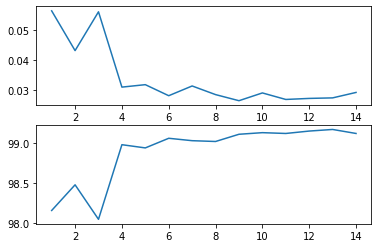

In [5]:
cc_list=[]
loss_list=[]
from __future__ import print_function
import argparse
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import logging
import bagua.torch_api as bagua
import bagua_core 
import time

bagua_core.install_deps()


# Model for Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

#------Training Model
def train(args, model, train_loader, optimizer, epoch):
    #??????? What does model.train() do exactly? Sets mode. 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #data: features , target: label
        data, target = data.cuda(), target.cuda()
        #Gradients are set back to zero here to avoid gradient accumulation
        optimizer.zero_grad()
        # Calculates predicted labels by using the model
        output = model(data)
        # Loss function using predicted labels and actual labels
        loss = F.nll_loss(output, target)
        # Backwards propagation    !!!calculates tensor loss gradient 
        loss.backward()
        # Optimizer step selection
        if args.fuse_optimizer:
            optimizer.fuse_step()
        else:
            optimizer.step()
        if batch_idx % args.log_interval == 0:
            logging.info(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    logging.info(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    return test_loss,correct


def main():
    # Training settings
    parser = argparse.ArgumentParser(description="PyTorch MNIST Example")
    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        metavar="N",
        help="input batch size for training (default: 64)",
    )
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=1000,
        metavar="N",
        help="input batch size for testing (default: 1000)",
    )

# set number of epochs here
    parser.add_argument(
        "--epochs",
        type=int,
        default=14,
        metavar="N",
        help="number of epochs to train (default: 14)",
    )
    parser.add_argument(
        "--lr",
        type=float,
        default=1.0,
        metavar="LR",
        help="learning rate (default: 1.0)",
    )
    parser.add_argument(
        "--gamma",
        type=float,
        default=0.7,
        metavar="M",
        help="Learning rate step gamma (default: 0.7)",
    )
    parser.add_argument(
        "--log-interval",
        type=int,
        default=10,
        metavar="N",
        help="how many batches to wait before logging training status",
    )
    parser.add_argument(
        "--save-model",
        action="store_true",
        default=False,
        help="For Saving the current Model",
    )

    parser.add_argument(
        "--algorithm",
        type=str,
        default="qsparselocal",
        help="gradient_allreduce, bytegrad, decentralized, low_precision_decentralized, qadam, async",
        #Add new algorithm for testing------------------
    )



    parser.add_argument(
        "--async-sync-interval",
        default=500,
        type=int,
        help="Model synchronization interval(ms) for async algorithm",
    )
    parser.add_argument(
        "--set-deterministic",
        action="store_true",
        default=False,
        help="set deterministic or not",
    )
    parser.add_argument(
        "--fuse-optimizer",
        action="store_true",
        default=False,
        help="fuse optimizer or not",
    )

    #args = parser.parse_args() 
    # New line below solves ipykernel_launcher.py: error: unrecognized arguments
    args, unknown = parser.parse_known_args()
    
    if args.set_deterministic:
        print("set_deterministic: True")
        np.random.seed(666)
        random.seed(666)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.manual_seed(666)
        torch.cuda.manual_seed_all(666 + int(bagua.get_rank()))
        torch.set_printoptions(precision=10)

    torch.cuda.set_device(bagua.get_local_rank())
    bagua.init_process_group()



    logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.ERROR)
    if bagua.get_rank() == 0:
        logging.getLogger().setLevel(logging.INFO)

    train_kwargs = {"batch_size": args.batch_size}
    test_kwargs = {"batch_size": args.test_batch_size}
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )

    if bagua.get_local_rank() == 0:
        dataset1 = datasets.MNIST(
            "../data", train=True, download=True, transform=transform
        )
        torch.distributed.barrier()
    else:
        torch.distributed.barrier()
        dataset1 = datasets.MNIST(
            "../data", train=True, download=True, transform=transform
        )

    dataset2 = datasets.MNIST("../data", train=False, transform=transform)
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        dataset1, num_replicas=bagua.get_world_size(), rank=bagua.get_rank()
    )
    train_kwargs.update(
        {
            "sampler": train_sampler,
            "batch_size": args.batch_size // bagua.get_world_size(),
            "shuffle": False,
        }
    )
    # Train and Test dataset
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    # ??????????  Throw the instantiation of the network onto the cuda dvice
    model = Net().cuda()
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)


    if args.algorithm == "gradient_allreduce":
        from bagua.torch_api.algorithms import gradient_allreduce

        algorithm = gradient_allreduce.GradientAllReduceAlgorithm()
    elif args.algorithm == "decentralized":
        from bagua.torch_api.algorithms import decentralized

        algorithm = decentralized.DecentralizedAlgorithm()
    elif args.algorithm == "low_precision_decentralized":
        from bagua.torch_api.algorithms import decentralized

        algorithm = decentralized.LowPrecisionDecentralizedAlgorithm()
    elif args.algorithm == "bytegrad":
        from bagua.torch_api.algorithms import bytegrad

        algorithm = bytegrad.ByteGradAlgorithm()
    elif args.algorithm == "qadam":
        from bagua.torch_api.algorithms import q_adam

        optimizer = q_adam.QAdamOptimizer(
            model.parameters(), lr=args.lr, warmup_steps=100
        )
        algorithm = q_adam.QAdamAlgorithm(optimizer)
    #################################################################    
    elif args.algorithm == "qsparselocal":
        learning_rate = 0.1
        # Set lower learning rate, no convergence for lr = 1
        optimizer = QSparseLocalOptimizer(
            model.parameters(), lr=learning_rate, schedule = 1
        )
        algorithm = QSparseLocalAlgorithm(optimizer)
    elif args.algorithm == "async":
        from bagua.torch_api.algorithms import async_model_average

        algorithm = async_model_average.AsyncModelAverageAlgorithm(
            sync_interval_ms=args.async_sync_interval,
        )
    else:
        raise NotImplementedError

    #  Model von Bagua
    model = model.with_bagua(
        [optimizer],
        algorithm,
        do_flatten=not args.fuse_optimizer,
    )

    # Optimizer from Bagua if args.fuse_optimizer==True
    if args.fuse_optimizer:
        optimizer = bagua.contrib.fuse_optimizer(optimizer)

    #------------ Loss, accuracy
    loss_list =[]
    acc_list = []

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    
    start = time.time()
    for epoch in range(1, args.epochs + 1):
        if args.algorithm == "async":
            model.bagua_algorithm.resume(model)

        train(args, model, train_loader, optimizer, epoch)

        if args.algorithm == "async":
            model.bagua_algorithm.abort(model)

        new_loss,new_acc =test(model, test_loader)
        loss_list.append(new_loss)
        acc_list.append(new_acc/100.0)
        scheduler.step()
        ####
        torch.cuda.empty_cache()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    # Used for measuring the time taken for the epochs themselves
    end = time.time()
    print("Elapsed time:",end-start)

    import matplotlib.pyplot as plt

    ep =[]


    for i in range(1, args.epochs + 1):
      ep.append(i)

    print("Current quantization method:",quantization_scheme)
    print("Learning rate:",learning_rate)
    print("Loss:",loss_list)
    print("Accuracy:",acc_list)
    
     

    plt.figure(1)
    plt.subplot(211)
    plt.plot(ep,loss_list)
    plt.subplot(212)
    plt.plot(ep,acc_list)

    plt.show()  
    


if __name__ == "__main__":
    main()

In [6]:
%tb

No traceback available to show.
